# Predicting Consumer Choices with Decision Tree and Logistic Regression

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.tree import DecisionTreeClassifier
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

%matplotlib inline

/Users/xiliang/anaconda3/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


This dataset was published by Sydney Transportation Study. Commuters have the freedom to choose to go into the city either by car or by train. Each observation contains time and cost required for specific commuter to travel into the city for work, the commuter would have to make the decision by him/herself to commute by eithe car or train.

# Load Data and Explore a Bit

In [2]:
df = pd.read_csv("data/sydney.csv")

In [3]:
df.head()

,cartime,carcost,traintime,traincost,choice
0,70,50,64,39,TRAIN
1,50,230,60,32,TRAIN
2,50,70,58,40,CAR
3,60,108,93,62,CAR
4,70,60,68,26,TRAIN


In [4]:
df.tail()

,cartime,carcost,traintime,traincost,choice
328,27,50,52,40,CAR
329,25,25,63,80,CAR
330,50,50,80,50,CAR
331,25,25,39,20,CAR
332,35,64,95,40,CAR


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333 entries, 0 to 332
Data columns (total 5 columns):
cartime      333 non-null int64
carcost      333 non-null int64
traintime    333 non-null int64
traincost    333 non-null int64
choice       333 non-null object
dtypes: int64(4), object(1)
memory usage: 13.1+ KB


We don't see any missing values

In [6]:
df.describe()

,cartime,carcost,traintime,traincost
count,333.000000,333.000000,333.000000,333.000000
mean,45.465465,57.753754,66.321321,38.219219
std,18.308670,33.551875,19.296561,14.497507
min,10.000000,8.000000,3.000000,7.000000
25%,30.000000,32.000000,56.000000,28.000000
50%,45.000000,50.000000,67.000000,36.000000
75%,60.000000,70.000000,76.000000,46.000000
max,95.000000,230.000000,145.000000,97.000000


There are total 4 numberic features with 333 obserations. Let's take a look.

## Reponse Variable

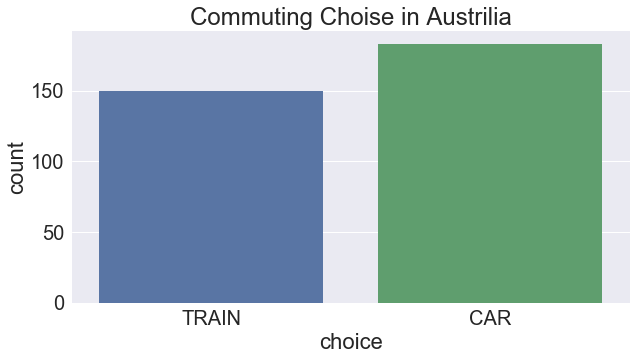

In [7]:
plt.figure(figsize=(10,5))
sns.set(font_scale=2)
plt.title('Commuting Choise in Austrilia')
sns.countplot(df.choice)

Most people prefer commuting with car.

## Numerical Features

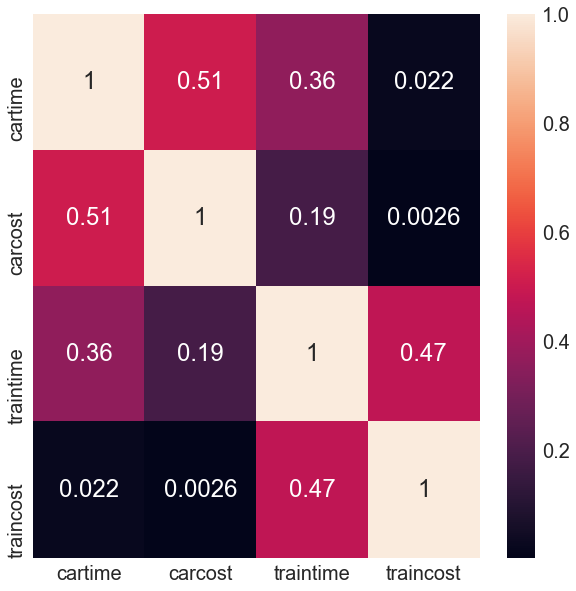

In [8]:
plt.figure(figsize=(10,10))
sns.set(font_scale=2)
sns.heatmap(df.iloc[:,0:4].corr(), annot= True)

We see that train time is correlated with train cost, and car cost is correlated with car time. In addition, train time is correlated with car time.

Let's look at some distribution.

In [9]:
cost_lib = {'carcost' : df.carcost, 'traincost': df.traincost}
cost_names = ['carcost', 'traincost']

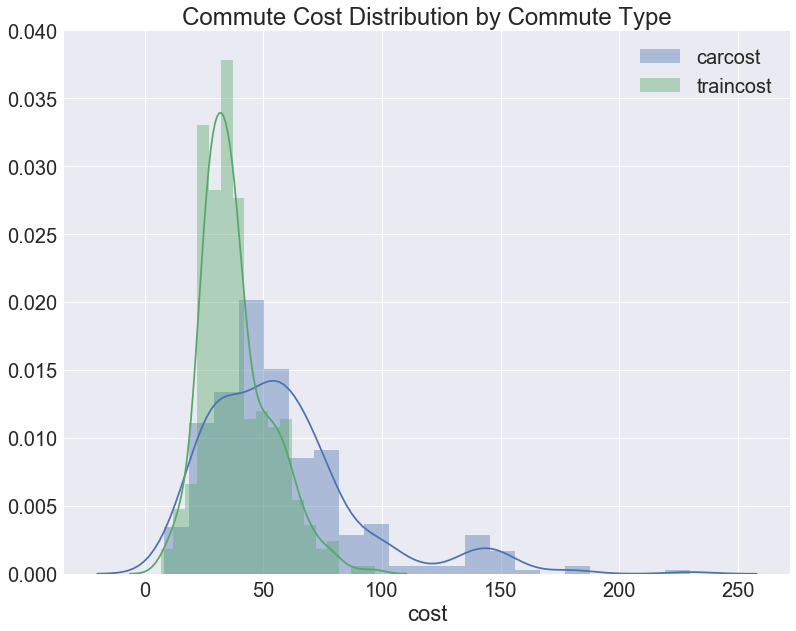

In [10]:
plt.figure(figsize=(13,10))
sns.set(font_scale=2)
plt.ylim(0,0.04)

for i in cost_names:
    ax = sns.distplot(cost_lib[i], label= str(i))
    plt.title('Commute Cost Distribution by Commute Type')
    plt.xlabel('cost')
ax.legend()

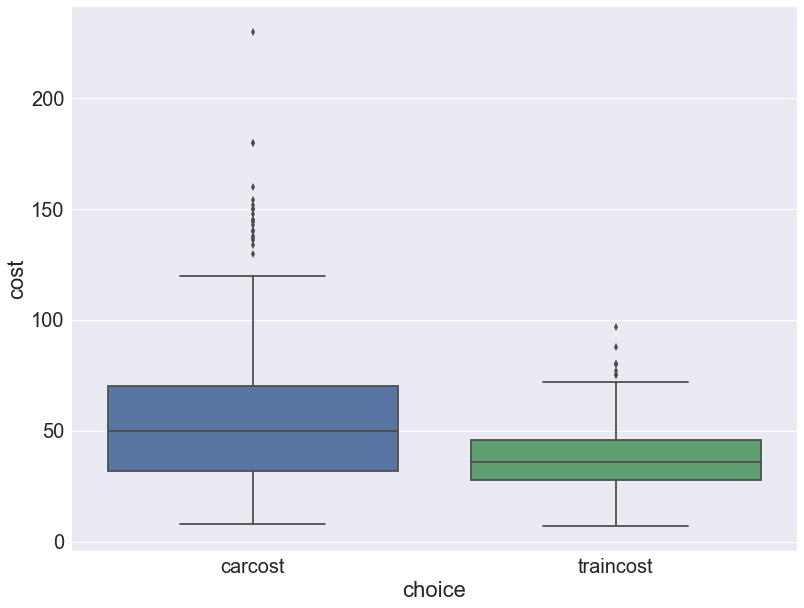

In [11]:
cost_melt_df = pd.melt(df[['carcost','traincost']], var_name= 'carcost')
cost_melt_df.columns = ['choice', 'cost']

plt.figure(figsize=(13,10))
sns.boxplot(x = 'choice', y = 'cost', data = cost_melt_df)

We can see that train cost was relatively more affordable than the car cost, in addtion, car cost has more extreme values comapred to train cost.

In [12]:
time_lib = {'cartime' : df.cartime, 'traintime': df.traintime}
time_names = ['cartime', 'traintime']

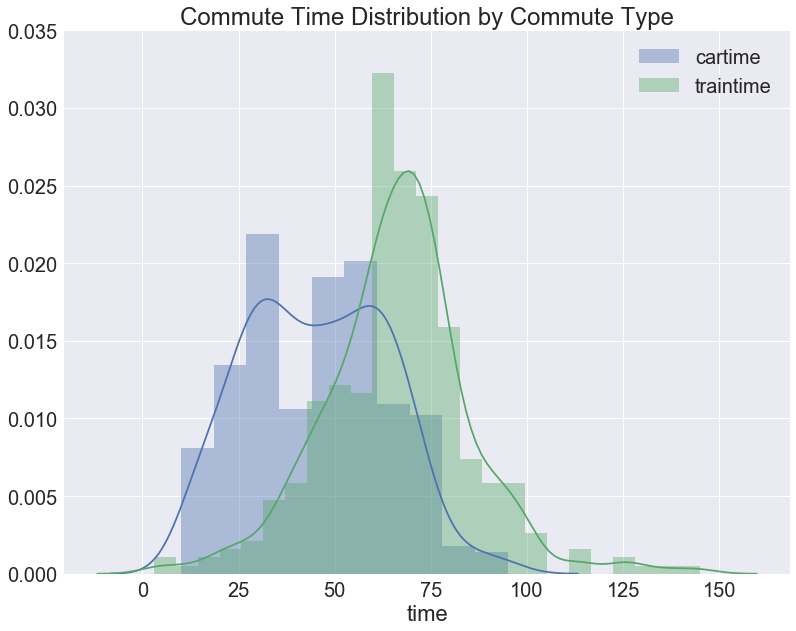

In [13]:
plt.figure(figsize=(13,10))
sns.set(font_scale=2)
plt.ylim(0,0.035)

for i in time_names:
    ax = sns.distplot(time_lib[i], label= str(i))
    plt.title('Commute Time Distribution by Commute Type')
    plt.xlabel('time')
ax.legend()

We see that car time has a bi-modal distribution probably because there are two general directions that commuters head into in the morning, one is generally closer to everyone, the other one is further. Train time's distribuction seems like a normal distribution.

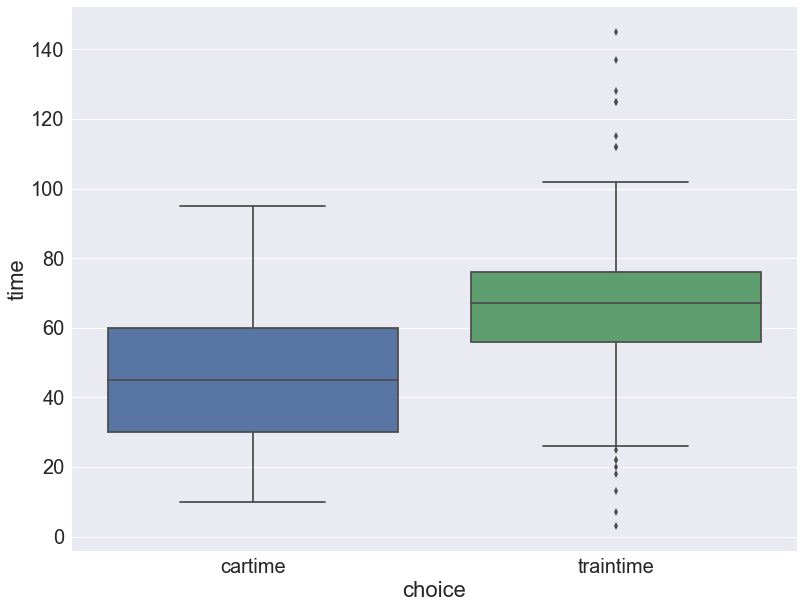

In [14]:
time_melt_df = pd.melt(df[['cartime','traintime']], var_name= 'cartime')
time_melt_df.columns = ['choice', 'time']

plt.figure(figsize=(13,10))
sns.boxplot(x = 'choice', y = 'time', data = time_melt_df)

# Viz via scatter plots

In [15]:
response_to_binary = {'TRAIN':1, 'CAR':0}
response = pd.DataFrame(df['choice'].map(response_to_binary))

In [16]:
colormap = ['red', 'lime']

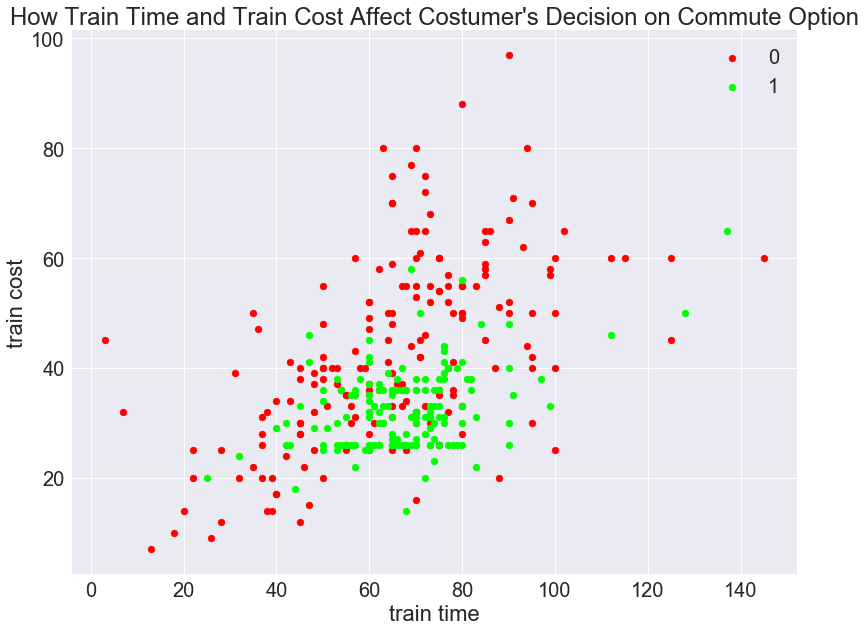

In [17]:
plt.figure(figsize=(13,10))
sns.set(font_scale=2)

x=df.traintime
y=df.traincost
classes = response.choice
unique = list(set(classes))
colors = [plt.cm.jet(float(i)/max(unique)) for i in unique]
for i, u in enumerate(unique):
    xi = [x[j] for j  in range(len(x)) if classes[j] == u]
    yi = [y[j] for j  in range(len(x)) if classes[j] == u]
    plt.scatter(xi, yi, c=colormap[i], label=str(u))
    
    
plt.legend()
plt.xlabel('train time')
plt.ylabel('train cost')
plt.title("How Train Time and Train Cost Affect Costumer's Decision on Commute Option")

From the scatterplot we observe that if train time were within 60 - 80 mins and the train costs were in the range 20 - 40, most consumer would choose commute with train. When the commute time got longer, people tend to drive to work.

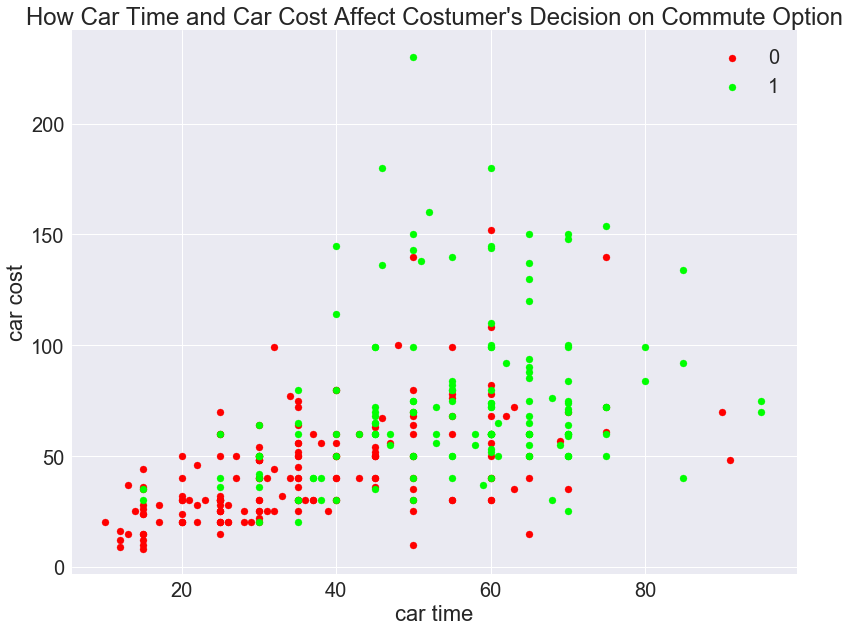

In [18]:
plt.figure(figsize=(13,10))
sns.set(font_scale=2)

x=df.cartime
y=df.carcost
classes = response.choice
unique = list(set(classes))
colors = [plt.cm.jet(float(i)/max(unique)) for i in unique]
for i, u in enumerate(unique):
    xi = [x[j] for j  in range(len(x)) if classes[j] == u]
    yi = [y[j] for j  in range(len(x)) if classes[j] == u]
    plt.scatter(xi, yi, c=colormap[i], label=str(u))
    
    
plt.legend()
plt.xlabel('car time')
plt.ylabel('car cost')
plt.title("How Car Time and Car Cost Affect Costumer's Decision on Commute Option")

# Viz via k-means

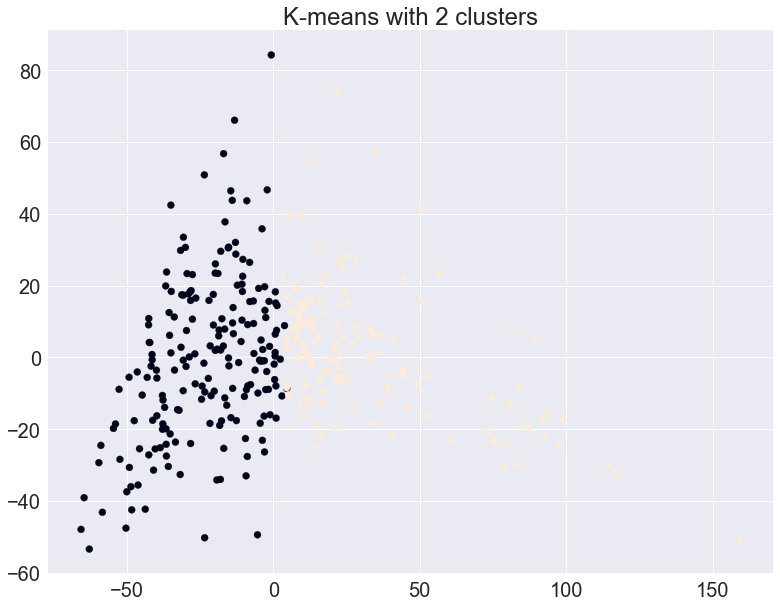

In [19]:
plt.figure(figsize=(13,10))
pca = PCA(n_components=2).fit(df.iloc[:,0:4])
pca_2d = pca.transform(df.iloc[:,0:4])

kmeans = KMeans(n_clusters=2, random_state=123)
kmeans.fit(df.iloc[:,0:4])
plt.title('K-means with 2 clusters')
plt.scatter(pca_2d[:, 0], pca_2d[:, 1], c=kmeans.labels_)

# Viz decision making with decision tree

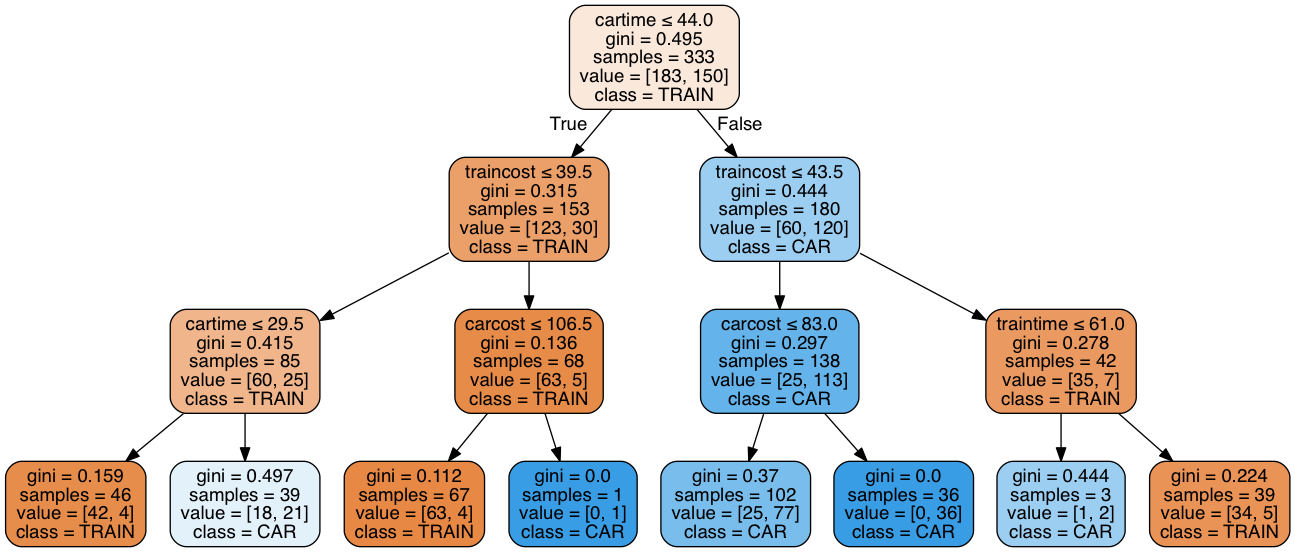

In [20]:
sydney = pd.read_csv("data/sydney.csv")

df=sydney.iloc[:,0:4]
y=sydney.choice


dtree=DecisionTreeClassifier(max_depth=3)
dtree.fit(df,y)

dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,
                feature_names= df.columns,
                class_names= ['TRAIN', 'CAR'],
                filled=True, rounded=True,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Based on the decision tree model, we see how customers made their decisions on taking train or car to the city, and most of the decisions were made at the first layer. When car time is less than or equal to 44 mintues, most people would choose train, when the car time is larger than 44 minutes, most people would choose car.

# Logistic Regression in Predicting Consumer Choice

We will use logistic regression to predict consumer behavior.

In [53]:
from sklearn import linear_model
from sklearn import model_selection
from sklearn.metrics import classification_report

x= sydney.iloc[:,0:4]
y= response.choice

X_train, X_test, y_train, y_test = model_selection.train_test_split(x, y, test_size = 0.2, random_state = 1234)

In [54]:
logit = linear_model.LogisticRegression(C = 1e5)
logit.fit(X_train, y_train)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [55]:
pred = logit.predict(X_test)

In [56]:
print(classification_report(pred, y_test))

             precision    recall  f1-score   support

          0       0.78      0.89      0.83        36
          1       0.85      0.71      0.77        31

avg / total       0.81      0.81      0.80        67

